# データ・サイエンス	データ・サイエンス社会応用論 / ICT社会応用演習Ⅳ
## 13-3. 基礎自治体の人口の確認

### 1. e-Stat のデータの読み込み
#### 1-a) 下準備

In [18]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import japanize_matplotlib

In [19]:
CENSUS_POPULATION_PATH = 'data/FEH_00200521_250109003235.csv'
LG_CODE_PATH = 'data/000925835.xlsx'
TOKYO_ADMIN_PATH = 'data/shape/N03-20240101_13.geojson'

#### 1-b) DataFrameへの読み込み

In [20]:
df_population = pd.read_csv(CENSUS_POPULATION_PATH, encoding='shift-jis', skiprows=14)
df_population

,時間軸（年次） コード,時間軸（年次） 補助コード,時間軸（年次）,全国，都道府県，市区町村（2000年市区町村含む） コード,全国，都道府県，市区町村（2000年市区町村含む） 補助コード,全国，都道府県，市区町村（2000年市区町村含む）,/男女,総数,男,女
0,2020000000,NaN,2020年,00000,NaN,全国,NaN,126146099,61349581,64796518
1,2020000000,NaN,2020年,01000,NaN,北海道,NaN,5224614,2465088,2759526
2,2020000000,NaN,2020年,01100,NaN,札幌市,NaN,1973395,918682,1054713
3,2020000000,NaN,2020年,01101,NaN,札幌市中央区,NaN,248680,112853,135827
4,2020000000,NaN,2020年,01102,NaN,札幌市北区,NaN,289323,136596,152727
...,...,...,...,...,...,...,...,...,...,...
4081,2020000000,NaN,2020年,47343,NaN,（旧：東風平町）,NaN,22106,10819,11287
4082,2020000000,NaN,2020年,47344,NaN,（旧：具志頭村）,NaN,8835,4425,4410
4083,2020000000,NaN,2020年,47375,NaN,多良間村,NaN,1058,575,483
4084,2020000000,NaN,2020年,47381,NaN,竹富町,NaN,3942,2033,1909


#### 1-c) DataFrameの下処理

In [21]:
df_population = df_population.rename(columns={
    '全国，都道府県，市区町村（2000年市区町村含む） コード': 'code',
    '全国，都道府県，市区町村（2000年市区町村含む）': 'name',
    '総数': 'total',
    '男': 'male',
    '女': 'female'
})
df_population['total'] = df_population['total'].apply(pd.to_numeric, errors='coerce')
df_population['male'] = df_population['male'].apply(pd.to_numeric, errors='coerce')
df_population['female'] = df_population['female'].apply(pd.to_numeric, errors='coerce')
df_population['ratio'] = df_population['male'] / df_population['female']
df_population = df_population[['code', 'name', 'total', 'male', 'female', 'ratio']]
df_population 

,code,name,total,male,female,ratio
0,00000,全国,126146099.0,61349581.0,64796518.0,0.946804
1,01000,北海道,5224614.0,2465088.0,2759526.0,0.893301
2,01100,札幌市,1973395.0,918682.0,1054713.0,0.871026
3,01101,札幌市中央区,248680.0,112853.0,135827.0,0.830858
4,01102,札幌市北区,289323.0,136596.0,152727.0,0.894380
...,...,...,...,...,...,...
4081,47343,（旧：東風平町）,22106.0,10819.0,11287.0,0.958536
4082,47344,（旧：具志頭村）,8835.0,4425.0,4410.0,1.003401
4083,47375,多良間村,1058.0,575.0,483.0,1.190476
4084,47381,竹富町,3942.0,2033.0,1909.0,1.064955


### 2. 地方公共団体コードの読み込み
#### 2-a) DataFrameへの読み込み

In [22]:
df_lg = pd.read_excel(LG_CODE_PATH, dtype=str)
df_lg

,団体コード,都道府県名\n（漢字）,市区町村名\n（漢字）,都道府県名\n（カナ）,市区町村名\n（カナ）
0,010006,北海道,NaN,ﾎｯｶｲﾄﾞｳ,NaN
1,011002,北海道,札幌市,ﾎｯｶｲﾄﾞｳ,ｻｯﾎﾟﾛｼ
2,012025,北海道,函館市,ﾎｯｶｲﾄﾞｳ,ﾊｺﾀﾞﾃｼ
3,012033,北海道,小樽市,ﾎｯｶｲﾄﾞｳ,ｵﾀﾙｼ
4,012041,北海道,旭川市,ﾎｯｶｲﾄﾞｳ,ｱｻﾋｶﾜｼ
...,...,...,...,...,...
1789,473618,沖縄県,久米島町,ｵｷﾅﾜｹﾝ,ｸﾒｼﾞﾏﾁｮｳ
1790,473626,沖縄県,八重瀬町,ｵｷﾅﾜｹﾝ,ﾔｴｾﾁｮｳ
1791,473758,沖縄県,多良間村,ｵｷﾅﾜｹﾝ,ﾀﾗﾏｿﾝ
1792,473812,沖縄県,竹富町,ｵｷﾅﾜｹﾝ,ﾀｹﾄﾐﾁｮｳ


#### 2-b) DataFrameの下処理

In [23]:
df_lg = df_lg.rename(columns = {
    '団体コード': 'code',
    '都道府県名\n（漢字）': 'prefecture',
    '市区町村名\n（漢字）': 'city'
})
df_lg = df_lg[['code', 'prefecture', 'city']]
df_lg

,code,prefecture,city
0,010006,北海道,NaN
1,011002,北海道,札幌市
2,012025,北海道,函館市
3,012033,北海道,小樽市
4,012041,北海道,旭川市
...,...,...,...
1789,473618,沖縄県,久米島町
1790,473626,沖縄県,八重瀬町
1791,473758,沖縄県,多良間村
1792,473812,沖縄県,竹富町


In [24]:
df_lg['code'] = df_lg['code'].apply(lambda x: x[:5])
df_lg = df_lg[~df_lg['code'].str.endswith('000')]
df_lg

,code,prefecture,city
1,01100,北海道,札幌市
2,01202,北海道,函館市
3,01203,北海道,小樽市
4,01204,北海道,旭川市
5,01205,北海道,室蘭市
...,...,...,...
1789,47361,沖縄県,久米島町
1790,47362,沖縄県,八重瀬町
1791,47375,沖縄県,多良間村
1792,47381,沖縄県,竹富町


### 3. 国勢調査のデータと基礎自治体データの結合
#### 3-a) DataFrameの結合

In [25]:
df_lg_population = df_population.merge(df_lg, how='inner')
df_lg_population

,code,name,total,male,female,ratio,prefecture,city
0,01100,札幌市,1973395.0,918682.0,1054713.0,0.871026,北海道,札幌市
1,01202,函館市,251084.0,113965.0,137119.0,0.831139,北海道,函館市
2,01203,小樽市,111299.0,50136.0,61163.0,0.819711,北海道,小樽市
3,01204,旭川市,329306.0,152108.0,177198.0,0.858407,北海道,旭川市
4,01205,室蘭市,82383.0,40390.0,41993.0,0.961827,北海道,室蘭市
...,...,...,...,...,...,...,...,...
1736,47361,久米島町,7192.0,3823.0,3369.0,1.134758,沖縄県,久米島町
1737,47362,八重瀬町,30941.0,15244.0,15697.0,0.971141,沖縄県,八重瀬町
1738,47375,多良間村,1058.0,575.0,483.0,1.190476,沖縄県,多良間村
1739,47381,竹富町,3942.0,2033.0,1909.0,1.064955,沖縄県,竹富町


#### 3-b) データの確認

In [26]:
df_lg_population.sort_values('total', ascending=False)

,code,name,total,male,female,ratio,prefecture,city
689,14100,横浜市,3777491.0,1867305.0,1910186.0,0.977551,神奈川県,横浜市
1112,27100,大阪市,2752412.0,1326875.0,1425537.0,0.930790,大阪府,大阪市
984,23100,名古屋市,2332176.0,1146669.0,1185507.0,0.967239,愛知県,名古屋市
0,01100,札幌市,1973395.0,918682.0,1054713.0,0.871026,北海道,札幌市
1468,40130,福岡市,1612392.0,761148.0,851244.0,0.894160,福岡県,福岡市
...,...,...,...,...,...,...,...,...
1731,47356,渡名喜村,346.0,206.0,140.0,1.471429,沖縄県,渡名喜村
681,13362,利島村,327.0,197.0,130.0,1.515385,東京都,利島村
685,13382,御蔵島村,323.0,181.0,142.0,1.274648,東京都,御蔵島村
687,13402,青ヶ島村,169.0,102.0,67.0,1.522388,東京都,青ヶ島村


In [27]:
df_lg_population.sort_values('ratio', ascending=False)

,code,name,total,male,female,ratio,prefecture,city
400,07545,大熊町,847.0,754.0,93.0,8.107527,福島県,大熊町
398,07543,富岡町,2128.0,1542.0,586.0,2.631399,福島県,富岡町
402,07547,浪江町,1923.0,1350.0,573.0,2.356021,福島県,浪江町
1733,47358,北大東村,590.0,367.0,223.0,1.645740,沖縄県,北大東村
688,13421,小笠原村,2929.0,1805.0,1124.0,1.605872,東京都,小笠原村
...,...,...,...,...,...,...,...,...
37,01331,松前町,6260.0,2805.0,3455.0,0.811867,北海道,松前町
1371,35502,阿武町,3055.0,1367.0,1688.0,0.809834,山口県,阿武町
1161,28206,芦屋市,93922.0,42008.0,51914.0,0.809184,兵庫県,芦屋市
1261,30422,太地町,2791.0,1229.0,1562.0,0.786812,和歌山県,太地町


### 4. コロプレス図の作成
#### 4-a) 行政区域データの読み込み

In [28]:
gdf_tokyo_admin = gpd.read_file(TOKYO_ADMIN_PATH)
gdf_tokyo_admin

,N03_001,N03_002,N03_003,N03_004,N03_005,N03_007,geometry
0,東京都,None,None,所属未定地,None,13000,"POLYGON ((140.28925 30.48135, 140.28968 30.480..."
1,東京都,None,None,所属未定地,None,13000,"POLYGON ((139.82167 35.58322, 139.82187 35.583..."
2,東京都,None,None,所属未定地,None,13000,"POLYGON ((139.84130 35.64702, 139.84129 35.646..."
3,東京都,None,None,所属未定地,None,13000,"POLYGON ((140.05004 31.43993, 140.05002 31.439..."
4,東京都,None,None,所属未定地,None,13000,"POLYGON ((140.34167 29.79385, 140.34174 29.793..."
...,...,...,...,...,...,...,...
6899,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.28634 24.79924, 141.28633 24.799..."
6900,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.29279 24.74890, 141.29278 24.748..."
6901,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.37959 24.78060, 141.37958 24.780..."
6902,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.29002 24.74740, 141.29002 24.747..."


#### 4-b) 地方公共団体コードでグルーピング

In [29]:
gdf_tokyo_admin_grouped = gdf_tokyo_admin.dissolve(by='N03_007')
gdf_tokyo_admin_grouped = gdf_tokyo_admin_grouped.reset_index()
gdf_tokyo_admin_grouped

,N03_007,geometry,N03_001,N03_002,N03_003,N03_004,N03_005
0,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None
1,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None
2,13102,"POLYGON ((139.78341 35.69645, 139.78334 35.696...",東京都,None,None,中央区,None
3,13103,"MULTIPOLYGON (((139.77115 35.62838, 139.77115 ...",東京都,None,None,港区,None
4,13104,"POLYGON ((139.73333 35.70770, 139.73321 35.707...",東京都,None,None,新宿区,None
...,...,...,...,...,...,...,...
58,13381,"MULTIPOLYGON (((139.38455 34.04434, 139.38458 ...",東京都,None,None,三宅村,None
59,13382,"MULTIPOLYGON (((139.29851 33.65146, 139.29837 ...",東京都,None,None,御蔵島村,None
60,13401,"MULTIPOLYGON (((139.83879 33.04832, 139.83878 ...",東京都,None,None,八丈町,None
61,13402,"MULTIPOLYGON (((139.76717 32.44306, 139.76718 ...",東京都,None,None,青ヶ島村,None


#### 4-c) 国勢調査のDataFrameを結合

In [30]:
gdf_tokyo_population = gdf_tokyo_admin_grouped.merge(df_population, left_on='N03_007', right_on='code')
gdf_tokyo_population

,N03_007,geometry,N03_001,N03_002,N03_003,N03_004,N03_005,code,name,total,male,female,ratio
0,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,14047594.0,6898388.0,7149206.0,0.964917
1,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,66680.0,33637.0,33043.0,1.017977
2,13102,"POLYGON ((139.78341 35.69645, 139.78334 35.696...",東京都,None,None,中央区,None,13102,中央区,169179.0,80931.0,88248.0,0.917086
3,13103,"MULTIPOLYGON (((139.77115 35.62838, 139.77115 ...",東京都,None,None,港区,None,13103,港区,260486.0,123410.0,137076.0,0.900303
4,13104,"POLYGON ((139.73333 35.70770, 139.73321 35.707...",東京都,None,None,新宿区,None,13104,新宿区,349385.0,174822.0,174563.0,1.001484
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,13381,"MULTIPOLYGON (((139.38455 34.04434, 139.38458 ...",東京都,None,None,三宅村,None,13381,三宅村,2273.0,1269.0,1004.0,1.263944
59,13382,"MULTIPOLYGON (((139.29851 33.65146, 139.29837 ...",東京都,None,None,御蔵島村,None,13382,御蔵島村,323.0,181.0,142.0,1.274648
60,13401,"MULTIPOLYGON (((139.83879 33.04832, 139.83878 ...",東京都,None,None,八丈町,None,13401,八丈町,7042.0,3534.0,3508.0,1.007412
61,13402,"MULTIPOLYGON (((139.76717 32.44306, 139.76718 ...",東京都,None,None,青ヶ島村,None,13402,青ヶ島村,169.0,102.0,67.0,1.522388


#### 4-d) 島嶼部の削除

In [31]:
min_lon, min_lat = 138.0, 35.0
max_lon, max_lat = 140.0, 36.0
   
bbox_polygon = Polygon([(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat)])

In [32]:
gdf_tokyo_population_clipped = gdf_tokyo_population[gdf_tokyo_population.within(bbox_polygon)]
gdf_tokyo_population_clipped

,N03_007,geometry,N03_001,N03_002,N03_003,N03_004,N03_005,code,name,total,male,female,ratio
1,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,66680.0,33637.0,33043.0,1.017977
2,13102,"POLYGON ((139.78341 35.69645, 139.78334 35.696...",東京都,None,None,中央区,None,13102,中央区,169179.0,80931.0,88248.0,0.917086
3,13103,"MULTIPOLYGON (((139.77115 35.62838, 139.77115 ...",東京都,None,None,港区,None,13103,港区,260486.0,123410.0,137076.0,0.900303
4,13104,"POLYGON ((139.73333 35.70770, 139.73321 35.707...",東京都,None,None,新宿区,None,13104,新宿区,349385.0,174822.0,174563.0,1.001484
5,13105,"POLYGON ((139.75000 35.73338, 139.75000 35.733...",東京都,None,None,文京区,None,13105,文京区,240069.0,115483.0,124586.0,0.926934
6,13106,"POLYGON ((139.76667 35.71330, 139.76667 35.713...",東京都,None,None,台東区,None,13106,台東区,211444.0,108586.0,102858.0,1.055688
7,13107,"POLYGON ((139.79517 35.70466, 139.79500 35.704...",東京都,None,None,墨田区,None,13107,墨田区,272085.0,134787.0,137298.0,0.981711
8,13108,"MULTIPOLYGON (((139.79859 35.59561, 139.79861 ...",東京都,None,None,江東区,None,13108,江東区,524310.0,258015.0,266295.0,0.968907
9,13109,"MULTIPOLYGON (((139.74949 35.59155, 139.74951 ...",東京都,None,None,品川区,None,13109,品川区,422488.0,208688.0,213800.0,0.976090
10,13110,"POLYGON ((139.68053 35.60445, 139.68054 35.604...",東京都,None,None,目黒区,None,13110,目黒区,288088.0,135820.0,152268.0,0.891980


#### 4-e) コロプレス図の表示

<Axes: >

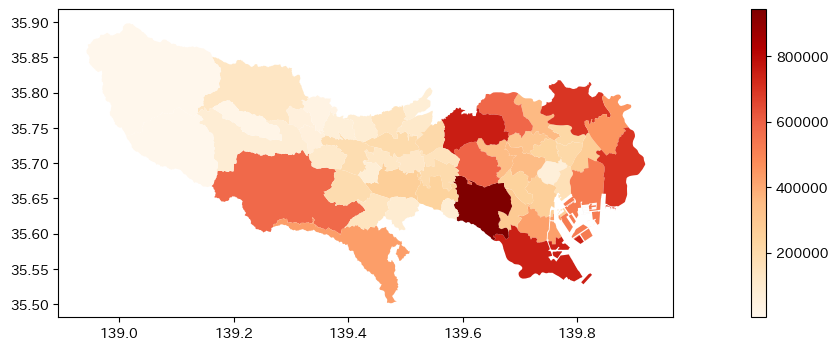

In [33]:
gdf_tokyo_population_clipped.plot(column='total', cmap='OrRd', legend=True, figsize=(20,4))

<Axes: >

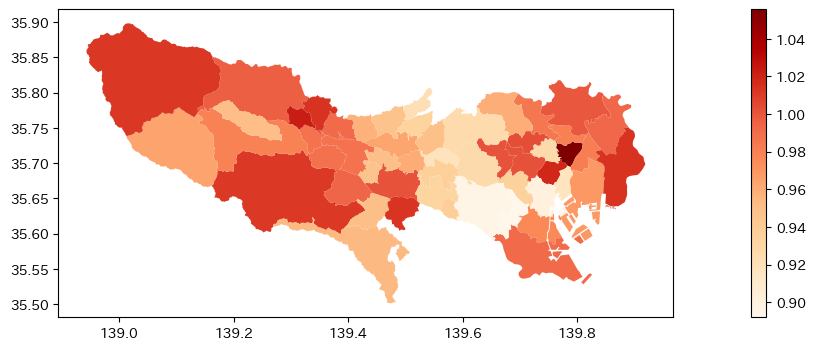

In [34]:
gdf_tokyo_population_clipped.plot(column='ratio', cmap='OrRd', legend=True, figsize=(20,4))